# Explainability: Bringing clarity to ML
### Using the Python package SHAP to understand and explain your models.

<img src="image.jpg" alt="Girl in a jacket" width="600" height="450">

SHAP can provide explanations of 
* why a model made a particular prediction
* how relatively important the different variables are
* and otherwise enable transparency.

## The problem: why do we need explainability?

#### As AI models are playing a more and more important role in people's lives, we have to be able to explain how they work.

* We currently have a lot of models that are making decisions affecting human lives, but it’s very difficult to understand what those decisions are based on.
* For example, many courtrooms are using algorithms to make decisions about sentencing.  People using the algorithms to make these life-changing decisions often do not understand why a particular prisoner is granted or denied bail.
* In some cases the programmer understands how a model works but the end user does not, in other cases  nobody knows what variables a model is using.
* I have two goals for explainability in my own work: 1) to be able to understand why a model makes a particular decision and 2) be able to explain it to other people. 

This notebook will walk you through a basic overview of what Shapley values are, and how to use them with the Python  SHAP package to help explain your models. It's based on the SHAP documentation, but simplified. I'm hoping to save you some of the time that it took me to figure out how they work!

## Installing shap:

Before you can run this notebook install SHAP with either:

pip install shap 

or 

conda install -c conda-forge shap

## Starting with Linear Regressions

#### We describe linear models with coefficients, but they don't explain the relative importance of variables.

We'll start out with the simplest possible model, a linear regression, and then move on from there.

Quick review of linear regressions:
* Linear regression creates a model like: housing price = 10,000 + 3 * age of house in years + 10 * rooms in house. 
* In this example, 3 and 10 are the coefficients.  They let us predict housing price plugging in the age of the house and the number of rooms. 
* However, they are not able to tell us how important the age of the house is compared to the number of rooms.  The size of the coefficients for the different variables doesn't tell us how heavily they are weighted in making the prediction.



### Now let's run a linear regression.

We'll use the famous diabetes dataset and try to predict the progression of diabetes based on different factors.

Some of these coefficients are not clear: here's more information from the scikit documentation:
* s1 tc, total serum cholesterol
* s2 ldl, low-density lipoproteins
* s3 hdl, high-density lipoproteins
* s4 tch, total cholesterol / HDL
* s5 ltg, possibly log of serum triglycerides level
* s6 glu, blood sugar level

(All of the factors have been normalized-- the values may not look as you expect them to.)

In [8]:
import pandas as pd
import shap
import sklearn

shap.datasets.diabetes

# load the diabetes dataset
X,y = shap.datasets.diabetes()
X100 = shap.utils.sample(X, 100) 

# create a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

LinearRegression()

Now that we've created the model, let's look at the coefficients:


In [9]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(4))

Model coefficients:

age = -10.0099
sex = -239.8156
bmi = 519.8459
bp = 324.3846
s1 = -792.1756
s2 = 476.739
s3 = 101.0433
s4 = 177.0632
s5 = 751.2737
s6 = 67.6267


### What's wrong with coefficients?  Introducing Shapley values.

#### Coefficients are dependent on unit of measurement and scale; that's why we need Shapley values.

Right now, measuring the age of the patient in years, we get a coefficient of about -10.  
* If we measure the age of the patient in hours instead, the new coefficient will be -10 * 365 * 24 = -87,600. 
* Suddenly age looks much more important then it did before.  
* However, the actual effect of a change in age on the prediction has not changed.  

This is why coeffiecients don't do a good enough job of explaining how much each variable affects a prediction.

To solve this problem, we'll use Shapley values.

#### A Shapley value explains how much a specific variable contributes to a specific prediction.  


You can think of a Shapely value as how much a prediction changes when a new variable is added; how much value is added by each new variable.

The underlying math for Shapley values is extremely complex.  However, in the case of linear regressions, they become much more simple to calulate.  



#### The next graph shows how s5 predicts progression of diabetes in our model.



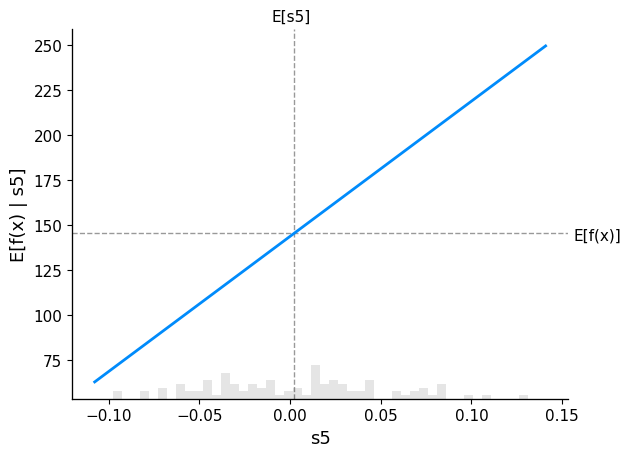

In [10]:
shap.partial_dependence_plot("s5", model.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True)

#### The blue line shows our predictions of price; the grey lines show the average number of rooms and average housing value.

* The x axis shows s5, ranging from -0.10 to 0.15.
* The grey squares along the x access are a histogram showing the distribution of s5; remember that the numbers have been normalized, so they cluster around 0.
* The y axis shows progression of diabetes; the higher the number, the worse the diabetes got.
* The blue line shows predictions.  To find the predicted price of a patient with 0.05 s5, look at that number on the x axis and look up to find the point on the blue line. .
* The grey dotted lines are averages.  There is a grey line dotted line running across from about 150 -- this is the average progression of the disease. The grey dotted line coming up from about 0 shows the average s5 level.  This makes sense, as it has has been normalized to make the average 0.  

Now let's zoom in on a single prediction.

#### The next graph shows how we compute the Shapley value for a single prediction.

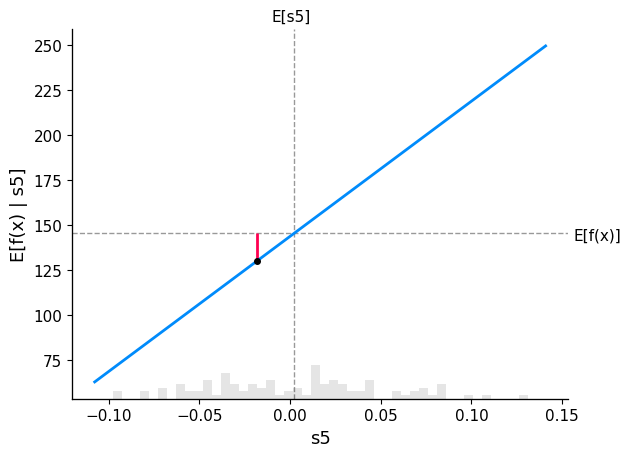

In [11]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 18
shap.partial_dependence_plot(
    "s5", model.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

#### The Shapley value for this prediction is the red line; the distance between the average diabetes progression and the progression we are predicting.

We're looking at the predicted change in diabetes when the s5 is -0.02.  Take a look at the  black dot on the blue line (the s5 and diabetes for this particular prediction) and the red line showing how far this value is from the diabetes score across all the patients. 

Note that this graph only shows predicted values-- we are not looking at any actual observations from real-world patients.

#### For each variable, each prediction has a different Shapley value.

Notice that each prediction has a different Shapley value.  For each prediction we make, the weight of variables used to make a prediction will be different.

* Each (linear, additive) predictor value we are looking at has a graph like this.  If there was a different graph for the diabetes of the next patient, we could measure the Shapley value for that patient, and then compare the two Shapley  graphs to see which factors had a greater influence.

#### Another way to think about Shapley values.

If we did not know the s5, and we needed to predict the diabetes progress for a single patient, we would predict the average score for all the patients.  This score is the horizontal dotted line on the graph.
* Now we've added a single variable:  the s5 for a particular patient.  Based on this new variable, we can get improve our prediction and get more specific then the average of all patients.
* Since higher s5 means worse diabetes, and this particular patient has lower then average s5, we can expect a diabetes score that is lower then average.
* The length of the red line shows us how much lower then the average score we expect to be for this particular patient.  
* In other words, the length of the red line tells us how much the fact that this patient has 0.02 s5 affects our prediction of diabetes score.
* This is the Shapley value.

### So what? Explaining a prediction with Shapley values.

#### Now that we've gone over what Shapley values are, let's look at how they can be used.

Earlier in the notebook we created a linear model with 10 predictor variables.  So far we've only looked at one variable-- s5.  Let's use Shapley values to see how s5 compares with the other 9 variables in the model to predict diabetes progression.

#### The next graph shows how all 10 variables affect the prediction for a single patient.

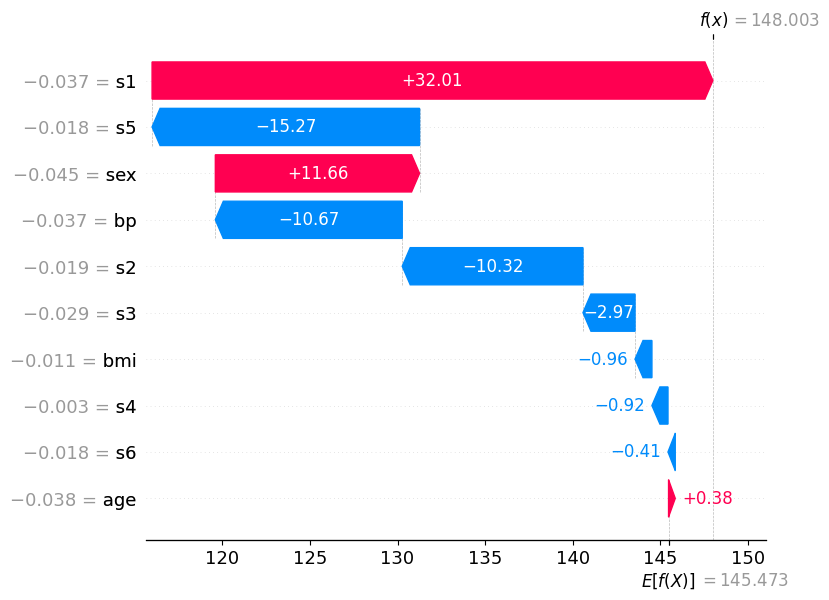

In [12]:
# the waterfall_plot shows how we use each variable to make a better prediction 
# then the average across all patients


shap.plots.waterfall(shap_values[sample_ind], max_display=10)

#### This graph shows how influential each variable is for a single prediction.

This graph shows a single prediction.  For a patient with (normalized) 29.54 s1, -19.19 of s5, etc, this graph
shows how important each variable is in making a prediction.
* The most important variables for this prediction are on the top, and they also have the longest bar.  For this prediction, s1 (blood sugar) is most imprtant, followed by s5.
* Red squares mean the variable makes the predicted diabetes score higher then average, blue squares lower then average.
* You can also read the graph from right to left to see what the prediction will be.  Start reading from the bottom.
* The average score for all patients is about 148.  Because this patient has a (normalized) age of -0.038 (below the average age of patients) we add 0.37 to diabetes score we are predicting for this particular patient.
* The next row up shows us that because this patient has s6 of -0.018, we subtract 0.98 from the predicted score
* Continuing to move up each row in the graph, we can see how our predicted house price will increase or decrease based on a particular variable.
* In the last step, we add 29.54 (due to high blood sugar) and get our prediction of 148.003.

#### This graph can explain a single prediction.

For example, if a judge runs a program and it tells her that a particular prisoner should get a longer sentence, 
the judge could look at a picture like this to see why that recommendation is being made.

The graph might show that the main reason this person is getting a long sentence is because he has been convicted of shooting three people.  Seems like a good call.

On the other hand, another prisoner's graph might show that the main reason for her long sentence is because of her zip code.  Seems like worth rethinking that one.

### Looking at more than one prediction.

#### The next two graphs show how variables work across all predictions.

So far we've showed how to explain a single prediction.  But what if we want to talk about all the predictions?    What if we want to look at the average Shapley values?

There’s a tricky thing here: Shapley values explain the difference between each observation and the mean.  If the mean is 0, half will be positive and half negative and they will average out to zero.



#### The next graph uses absolute values to show how significant variables are across all predictions:

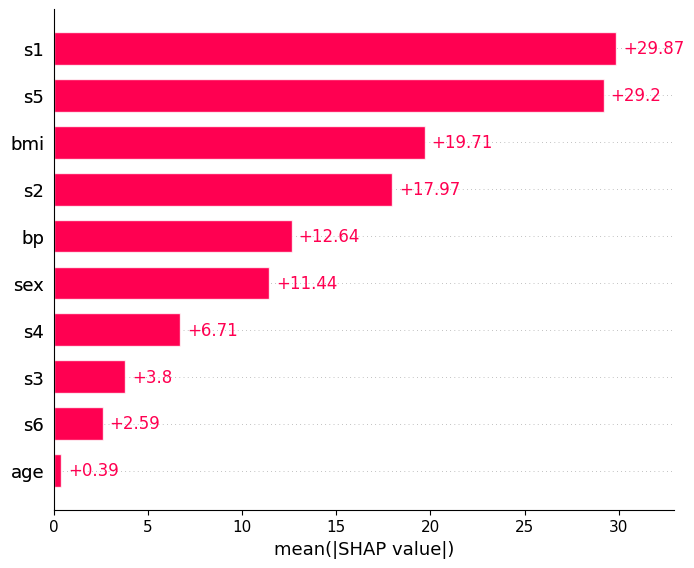

In [13]:
shap.plots.bar(shap_values)

Looking at the average impact of different variables, we can see that s5 is the most important predictor variable on average.  Blood sugar (s6) is still important, but it's not the most important on average.

What about if we have a factor that matters a lot for a small number of observations?  We can look at the maximum Shapley values instead:

#### The next graph shows any variables that are deeply influential, but only for a few predictions.

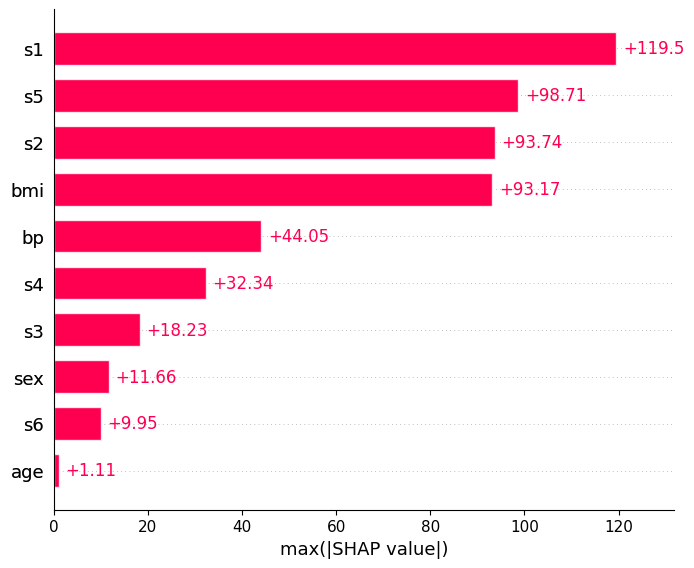

In [14]:
shap.plots.bar(shap_values.abs.max(0))

This graph will highlight if there is one variable that doesn’t influence many observations, but when it does it makes a huge difference. In our bail example, we might want prior conviction for murder to work like this.  Most people don't have a conviction for murder so it doesn't impact the decision, but in those cases where someone does have a previous murder conviction it should trump other factors and lead to a decision to deny bail.

There's a lot more out there-- Shapley values can be used to explain a lot of different kinds of models. 

### Assumptions and options

#### So far we've looked at a very simple model, which makes Shapley values easier to calculate.

So far we've been assuming:
* We are looking at a linear regression model— which simplifies the math and makes Shapley values easier to calculate.  
* We're assuming every predictor is independent.  
* We're also looking at additive models.  In the graphs above, you see that you can add the effect of each variable to get the final prediction.

#### The SHAP package can also explain more complex models.

* SHAP can also work with nonlinear models, non-additive models, and correlated features. These are more complicated and require more research. 


SHAP gets more exciting when it's used on more complicated models.  

#### The next image shows how SHAP can explain a model analyzing sentiment for a block of text:

<img src="sentiment_analysis.png" alt="Girl in a jacket" width="600" height="200">

This more complicated example starts to show how SHAP can be useful in explaining more confusing models-- red shows phrases the model saw as positive, blue as negative.

## Conclusion

#### Use the SHAP package along with your models to make them more explainable.

This has been a quick introduction into why we need explainability, what shapley values are, and how to use the SHAP package in Python to explain your models.  

As more and more life-threatening decisions are made by models that are designed to be incomprehensible, we absolutely must do a better job explaining how our models work.

This has just been a start-- I've covered only some of the material from the first introduction to the SHAP package documentation at https://shap.readthedocs.io.  Dig in and let me know what you find!


Notebook created by Nabil Arnaoot 
on 2/14/2022 and revised 6/22/2023

* heavily relying on SHAP documentation particularly <a href="https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html">An introduction to explainable AI with Shapley values</a>
* examples and explanations pulled from that introduction; see link for more
* with deep gratitude for help with the underlying math from Laura Riccio.

This notebook only covers only a small part of the SHAP introduction available at https://shap.readthedocs.io.